In [1]:
#!pip install -q torch==1.7.1+cpu torchvision==0.8.2+cpu torchaudio===0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

In [2]:
#!pip install -q --no-index torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cpu.html
#!pip install -q --no-index torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cpu.html
#!pip install -q --no-index torch-cluster -f https://pytorch-geometric.com/whl/torch-1.7.0+cpu.html
#!pip install -q --no-index torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.7.0+cpu.html
#!pip install torch-geometric

In [3]:
import torch
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from torch_geometric.data import NeighborSampler
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import collections

from modules.model import Net
from modules.sampling import Sampler

In [4]:
dataset =Planetoid(root='/tmp/Cora', name='Cora',transform=T.NormalizeFeatures())
data = dataset[0]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x = data.x.to(device)
y = data.y.squeeze().to(device)

In [5]:
arr=torch.nonzero((data.train_mask == True))
indices_of_train_data = ([item for sublist in arr for item in sublist])

In [6]:
train_loader = NeighborSampler(data.edge_index, node_idx=data.train_mask, batch_size = 256, sizes=[25, 10],
                               shuffle=True)
def train(model,data,optimizer,PosNegSampler):
    model.train()        
    total_loss = 0
    optimizer.zero_grad()
    if model.mode == 'unsupervised':
        if model.conv=='GCN':
            out = model.inference(data.to(device))
            pos_batch,neg_batch = PosNegSampler.sample(indices_of_train_data)
            
            loss = model.loss(out[data.train_mask], pos_batch.to(device), neg_batch.to(device))
            total_loss+=loss
        else:
            for batch_size, n_id, adjs in train_loader:
                # `adjs` holds a list of `(edge_index, e_id, size)` tuples.
                adjs = [adj.to(device) for adj in adjs]
                out = model.forward(data.x[n_id].to(device), adjs)
                pos_batch,neg_batch = PosNegSampler.sample(list((collections.Counter((adjs[1].edge_index[1]).tolist()).keys())))
                loss = model.loss(out, pos_batch.to(device), neg_batch.to(device))
                total_loss+=loss
        total_loss.backward(retain_graph=True)
        optimizer.step()      
        return total_loss /len(train_loader)
    elif model.mode== 'supervised':
        if model.conv=='GCN':
            out = model.inference(data.to(device))
            loss = model.loss_sup(out[data.train_mask],y[data.train_mask])
            total_loss+=loss
        else:
            for batch_size, n_id, adjs in train_loader:
                adjs = [adj.to(device) for adj in adjs]
                out = model.forward(data.x[n_id].to(device), adjs)
                loss = model.loss_sup(out,y[n_id[:batch_size]])
                total_loss+=loss
        total_loss.backward(retain_graph=True)
        optimizer.step()      
        return total_loss /len(train_loader)       

@torch.no_grad()
def test(model,data): 
    model.eval()
    out = model.inference(data.to(device))
    y = data.y.squeeze().to(device)
    y_true = y.cpu().detach().numpy()
    if model.mode == 'supervised':
        y_true = y.cpu().unsqueeze(-1)
        y_pred = out.cpu().argmax(dim=-1, keepdim=True)
        accs = []
        for mask in [data.train_mask, data.val_mask, data.test_mask]:    
            accs+=[int(y_pred[mask].eq(y_true[mask]).sum()) / int(mask.sum())]
        return accs
    elif model.mode == 'unsupervised':
        clf =MLPClassifier(random_state=1, max_iter=3000)#
        clf.fit(out[data.train_mask].cpu().detach().numpy(),y_true[data.train_mask.cpu()])
        accs = []
        for mask in [data.train_mask,data.val_mask, data.test_mask]:    
            accs += [(clf.score(out.cpu().detach()[mask].numpy(), y.cpu().detach()[mask].cpu().numpy()))]
        return accs
    

**Для начала посмотрим, что получится, если передать только фичи. Без обучения**

In [7]:
#в датасете планетоид все фичи это 0 кроме какой-то одной, не уверена, что это актуальное сравнение 
from sklearn.metrics import accuracy_score
y_true = y.cpu().detach().numpy()
clf = MLPClassifier(random_state=1, max_iter=3000).fit(x[data.train_mask].cpu().detach().numpy(),y_true[data.train_mask])
y_pred = clf.predict(x.cpu().detach().numpy())

results = []
for mask in [data.train_mask, data.val_mask, data.test_mask]:  
    results += [(clf.score(x.cpu().detach()[mask].numpy(), y.cpu().detach()[mask].numpy()))]
log = 'Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
print(log.format(results[0], results[1], results[2]))        

Train: 1.0000, Val: 0.5380, Test: 0.5270


**Теперь сравним с результатом после обучения эмбедингов**

conv: SAGE, mode: unsupervised, loss from VERSE
Validation acc on the last epoch  0.58


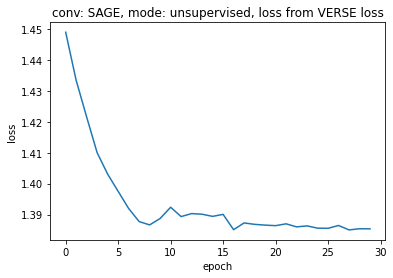

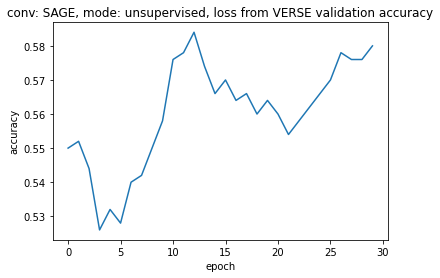

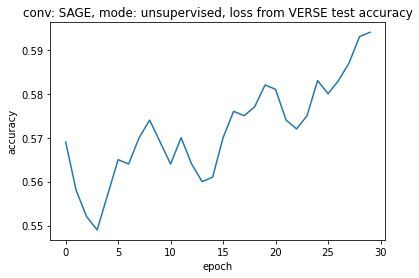

In [8]:
models = [Net(dataset = dataset,mode='supervised',conv='GCN',device=device), Net(dataset = dataset,mode='supervised',conv='GAT',device=device),Net(dataset = dataset,mode='supervised',conv='SAGE',device=device), Net(dataset = dataset,mode='unsupervised',conv='GCN',device=device),Net(dataset = dataset,mode='unsupervised',conv='GAT',device=device),Net(dataset = dataset,mode='unsupervised',conv='SAGE',device=device)]

SAGE = {"Name":"SAGE" , "walk length":5,"walks per node":50,"num negative samples":20,"context size" : 10,"p":1,"q":1, "loss var": "Random Walks"}
DeepWalk = {"Name": "DeepWalk","walk length":40,"walks per node":80,"num negative samples":20,"context size" : 10,"p":1,"q":1,"loss var": "Random Walks" }
Node2Vec = {"Name": "Node2Vec","walk length":100,"walks per node":18,"num negative samples":20,"context size" : 16,"p":1.414 ,"q":1.414, "loss var": "Random Walks"}
LINE2 = {"Name": "LINE2","C": "Adj","num negative samples":1,"loss var": "Context Matrix"}
VERSE =  {"Name": "VERSE","C": "PPR","num negative samples":1,"loss var": "Context Matrix"}


for Conv in ['SAGE']:
    for loss in [VERSE]:
        PosNegSampler = Sampler(data,device=device,mask=data.train_mask,loss_info=loss)
        model = Net(dataset = dataset,mode='unsupervised',conv=Conv,loss_function=loss["loss var"],device=device)
        model.to(device)
        
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
        
        losses=[]
        train_accs=[]
        test_accs=[]
        val_accs=[]
        name_of_plot='conv: '+model.conv+', mode: '+model.mode+', loss from '+loss["Name"]
       
        print(name_of_plot)
        
        for epoch in range(0, 30):
            loss = train(model,data,optimizer,PosNegSampler)
            losses.append(loss)
            train_acc, val_acc, test_acc = test(model,data)
            train_accs.append(train_acc)
            test_accs.append(test_acc)
            val_accs.append(val_acc)
            scheduler.step()
            #log = 'Loss: {:.4f}, Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
            #print(log.format(loss, epoch, train_acc, val_acc, test_acc))
            
        print('Validation acc on the last epoch ', val_acc)
        plt.plot(losses)
        plt.title(name_of_plot+' loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.show()


        plt.plot(val_accs)
        plt.title(name_of_plot+' validation accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.show()

        plt.plot(test_accs)
        plt.title(name_of_plot+' test accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.show()